In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from tqdm.notebook import tqdm
from torch.autograd import Variable

# Часть вторая: добавим нейронных сетей

In [2]:
class TicTacToe:
    def __init__(self, board_rows, board_cols, num_counts):
        self.board = np.zeros(board_rows * board_cols, dtype = int)
        self.isEnd = False
        self.playerName = 1
        self.board_rows = board_rows
        self.board_cols = board_cols
        self.num_counts = num_counts
        
    def getHash(self):
        return self.board

    def winner(self):
        board1 = self.board.reshape((self.board_rows, self.board_cols))
        for i in range(self.board_rows):
            sum_row = np.sum(board1[i, :])
            sum_col = np.sum(board1[:, i])
            if sum_row == self.num_counts or sum_col == self.num_counts:
                self.isEnd = True
                return 1
            elif sum_row == -self.num_counts or sum_col == -self.num_counts:
                self.isEnd = True
                return -1
        
        diag_sum1 = 0
        diag_sum2 = 0
        for i in range(self.board_cols):
            diag_sum1 += board1[i, i]
            diag_sum2 += board1[i, self.board_cols - i - 1]
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == self.num_counts:
            if diag_sum1 == self.num_counts or diag_sum2 == self.num_counts:
                self.isEnd = True
                return 1
            else:
                self.isEnd = True
                return -1

        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        self.isEnd = False
        return None
    
    def game_is_end(self):
        return self.isEnd
    
    def get_reward(self):
        win = self.winner()
        if not self.isEnd:
            return 0
        return win
    
    def updateState(self, position):
        self.board[position] = self.playerName
        self.playerName = -1 if self.playerName == 1 else 1
    
    def availablePositions(self):
        return np.where(self.board==0)[0]
    
    def availablePositionsBoard(self, board):
        return np.where(board==0)[0]
        
    def reset(self):
        self.board = np.zeros(self.board_rows * self.board_cols, dtype = int)
        self.isEnd = False
        self.playerName = 1

In [3]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
    
    def replace_last_reward(self, tensor_new_reward):
        tmp = list(self.memory[-1])
        tmp[3] = tensor_new_reward
        self.memory[-1] = tuple(tmp)
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    def __init__(self, size_deck, layer_size=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(size_deck, layer_size)
        self.l2 = nn.Linear(layer_size, size_deck)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [5]:
class DuelingDQN(nn.Module):
    def __init__(self, size_deck, layer_size=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(size_deck, layer_size)
        self.l2 = nn.Linear(layer_size, size_deck)
        self.l3 = nn.Linear(layer_size, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x1 = self.l2(x)
        x2 = self.l3(x)
        return x2 + (x1 - x1.mean())

In [6]:
class Player:
    def __init__(self, board_rows, board_cols, type_network='DQN', 
                 lr=0.001, gamma=0.8, batch_size=64, size_memory=10000):
        
        self.size_deck = board_cols * board_rows
        self.memory = ReplayMemory(size_memory)
        
        if type_network == 'DQN':
            self.model = DQN(size_deck=self.size_deck, layer_size=128)
        elif type_network == 'DuelingDQN':
            self.model = DuelingDQN(size_deck=self.size_deck, layer_size=128)
            
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        
        self.steps_done = 0
        self.episode_durations = []
        self.num_step = 0
        
    def select_greedy_action(self, state_tensor, available_position):
        actions_tensor = self.model(state_tensor).view(-1)
        pos_max = actions_tensor[available_position].max(-1)[1].item()
        return torch.tensor([[available_position[pos_max]]], dtype=torch.int64)
    
    def select_random_action(self, available_position):
        return torch.tensor([[random.choice(available_position)]], dtype=torch.int64)
    
    def select_action(self, state_tensor, available_position):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state_tensor, available_position)
        else:
            return self.select_random_action(available_position)

In [7]:
class Game:
    def __init__(self, p1, p2, board_rows, board_cols, num_counts):
        
        self.p1 = p1
        self.p2 = p2
        self.board = TicTacToe(board_rows, board_cols, num_counts)
        self.ep = 1

    def fit(self, episod_fit=1000, episod_validate=100, delta_validate=100):
        self._fig, self._ax = plt.subplots(figsize=(8, 6))
        dict_data = {-1:[], 0:[], 1:[]}
        mean_data = []
        data_x = []
        
        for i in tqdm(range(episod_fit+1)):
            if i % delta_validate == 0:
                mean, dict_res = self._validate(episod_validate)
                data_x.append(i)
                mean_data.append(mean)
                dict_data[1].append(dict_res[1]/episod_validate)
                dict_data[0].append(dict_res[0]/episod_validate)
                dict_data[-1].append(dict_res[-1]/episod_validate)
                self._draw_plot(episod_fit, data_x, mean_data, dict_data[1], dict_data[0], dict_data[-1])

            if i < episod_fit:
                self._run_episode(do_learning=True, greedy=False)
    
    def _run_episode(self, do_learning=True, greedy=False):
        
        self.board.reset()
        state = self.board.getHash()
        done = False   
        while not done:
            # Player 1
            self.current_player = self.p1
            available_position = self.board.availablePositions()  
            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if do_learning:
                    if greedy:
                        action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                    else:
                        action_tensor = self.current_player.select_action(state_tensor, available_position)
                else:
                    if greedy:
                        action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                    else:
                        action_tensor = self.current_player.select_action(state_tensor, available_position)

            self.board.updateState(action_tensor.numpy()[0][0])
            reward = self.board.get_reward()
            next_state = self.board.getHash()
            done = self.board.game_is_end()
            if do_learning:
                next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
                transition = (state_tensor, 
                              action_tensor, 
                              next_state_tensor, 
                              torch.tensor([reward], dtype=torch.int32))
                if done:
                    self.p2.memory.replace_last_reward(torch.tensor([-1], dtype=torch.int32))
                self.current_player.memory.store(transition)
                self._learn()
            
            if done:
                return reward
                
            else:
                state = next_state
                # Player 2
                self.current_player = self.p2
                available_position = self.board.availablePositions()  
                state_tensor = torch.tensor([state], dtype=torch.float32)
                with torch.no_grad():
                    if do_learning:
                        if greedy:
                            action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                        else:
                            action_tensor = self.current_player.select_action(state_tensor, available_position)
                    else:
                        if greedy:
                            action_tensor = self.current_player.select_random_action(available_position)
                        else:
                            action_tensor = self.current_player.select_random_action(available_position)

                self.board.updateState(action_tensor.numpy()[0][0])
                reward = self.board.get_reward()
                next_state = self.board.getHash()
                done = self.board.game_is_end()
                
                if do_learning:
                        next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
                        transition = (state_tensor, 
                                      action_tensor, 
                                      next_state_tensor, 
                                      torch.tensor([-reward], dtype=torch.int32))
                        if done:
                            self.p1.memory.replace_last_reward(torch.tensor([-1], dtype=torch.int32))
                        self.current_player.memory.store(transition)
                        self._learn()

                if done:
                    return reward
                state = next_state

    def _transform_state_to_action(self, matrix_output, batch_state):
        result = np.zeros(batch_state.shape[0])
        for i in range(batch_state.shape[0]):
            ind = self.board.availablePositionsBoard(batch_state[i])
            if len(ind)>0:
                result[i] = np.max(matrix_output[i][ind])
            else:
                result[i] = np.max(matrix_output[i])
        return result
    
    def _learn(self):
        mem = self.current_player.memory
        if len(mem.memory) < self.current_player.batch_size:
            return
        
        transitions = mem.sample(self.current_player.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        
        Q = self.current_player.model(batch_state).gather(1, batch_action).reshape([self.current_player.batch_size])
        
        model_next_state = self.current_player.model(batch_next_state)
        
        Qmax = torch.tensor(self._transform_state_to_action(model_next_state.detach().numpy(), 
                                                           batch_next_state), 
                            dtype=torch.float32)
        Qnext = batch_reward + (self.current_player.gamma * Qmax)

        loss = F.smooth_l1_loss(Q, Qnext)
        self.current_player.optimizer.zero_grad()
        loss.backward()
        self.current_player.optimizer.step()
       
    def _validate(self, episod_validate):
        counts = 0
        dict_res = {-1:0, 0:0, 1:0}
        for i in range(episod_validate):
            rew = self._run_episode(do_learning=False, greedy=True)
            dict_res[rew] += 1
            counts += rew  
        mean = counts/episod_validate
        return mean, dict_res
    
    def _draw_plot(self, rounds, data_x, data_y, data_y1, data_y2, data_y3):
        self._ax.clear()
        self._ax.plot(data_x, data_y1, 'go-', label='Доля побед')
        self._ax.plot(data_x, data_y2, 'b^--', label='Доля ничьих')
        self._ax.plot(data_x, data_y3, 'rs-.', label='Доля поражений')
        self._ax.set_title('Исходы игры',
                           fontdict={'fontsize': 12},
                          )
        self._ax.set_ylabel('Доля побед, ничьих, поражений',
                            fontdict={'fontsize': 10},
                           )
        self._ax.set_xlabel('Итерации обучения',
                            fontdict={'fontsize': 10},
                           )
        self._ax.legend(loc='best')
        self._ax.set_xlim([0, rounds])
        self._ax.set_ylim([0, 1.0])
        self._fig.canvas.draw()

## Крестики-нолики 3x3 DQN

<IPython.core.display.Javascript object>


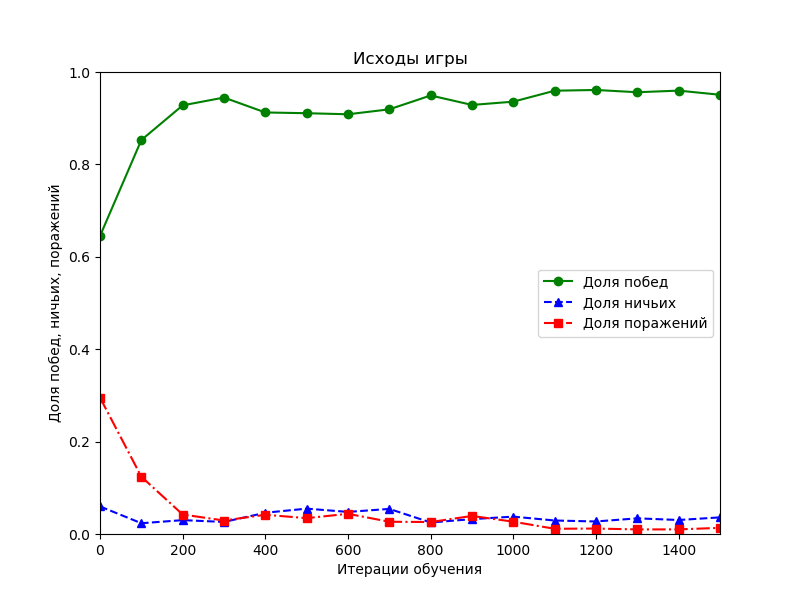

In [8]:
%matplotlib notebook

# Размер доски
board_cols, board_rows, num_counts = 3, 3, 3 

# Игроки
player_1 = Player(board_cols,
                  board_rows,
                  type_network='DQN',
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
player_2 = Player(board_cols,
                  board_rows,
                  type_network='DQN',
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
# Игра
game = Game(player_1, 
            player_2, 
            board_rows, 
            board_cols, 
            num_counts
           )

game.fit(episod_fit=1500,
         episod_validate=10000,
         delta_validate=100,
        )

## Крестики-нолики 3x3 DuelingDQN

<IPython.core.display.Javascript object>


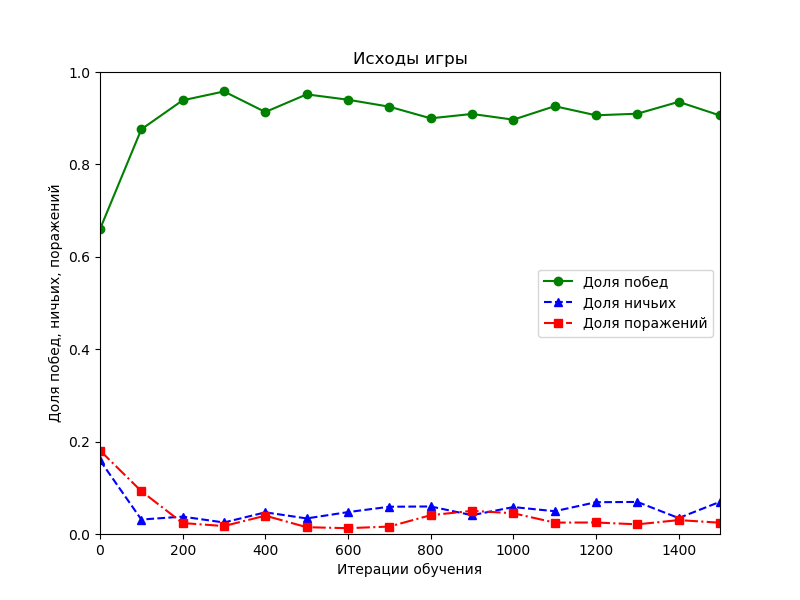

In [9]:
%matplotlib notebook

# Размер доски
board_cols, board_rows, num_counts = 3, 3, 3 

# Игроки
player_1 = Player(board_cols,
                  board_rows,
                  type_network='DuelingDQN',
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
player_2 = Player(board_cols,
                  board_rows,
                  type_network='DuelingDQN',
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
# Игра
game = Game(player_1, 
            player_2, 
            board_rows, 
            board_cols, 
            num_counts
           )

game.fit(episod_fit=1500,
         episod_validate=10000,
         delta_validate=100,
        )

## Крестики-нолики 4x4 DQN

<IPython.core.display.Javascript object>


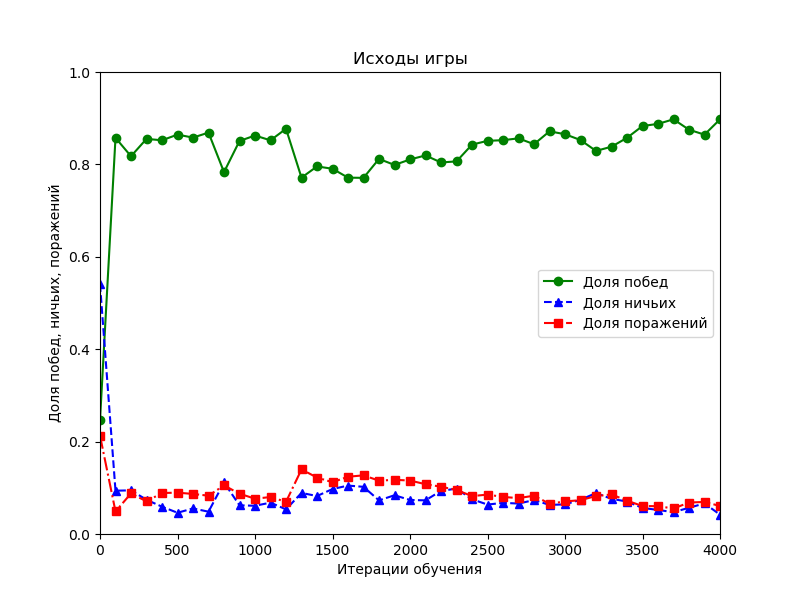

In [10]:
%matplotlib notebook

# Размер доски
board_cols, board_rows, num_counts = 4, 4, 4

# Игроки
player_1 = Player(board_cols,
                  board_rows,
                  type_network="DQN",
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
player_2 = Player(board_cols,
                  board_rows,
                  type_network="DQN",
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
# Игра
game = Game(player_1, 
            player_2, 
            board_rows, 
            board_cols, 
            num_counts
           )

game.fit(episod_fit=4000,
         episod_validate=10000,
         delta_validate=100,
        )

## Крестики-нолики 4x4 Dueling DQN

<IPython.core.display.Javascript object>


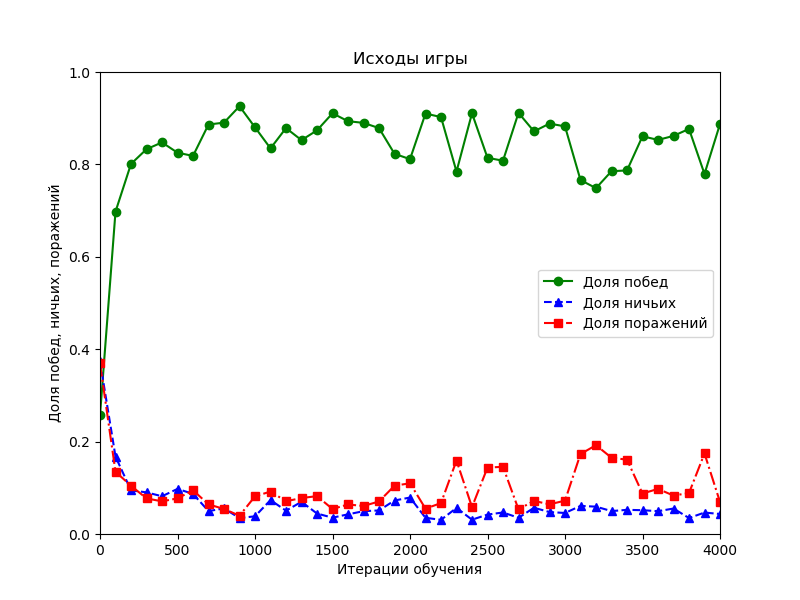

In [12]:
%matplotlib notebook

# Размер доски
board_cols, board_rows, num_counts = 4, 4, 4

# Игроки
player_1 = Player(board_cols,
                  board_rows,
                  type_network="DuelingDQN",
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
player_2 = Player(board_cols,
                  board_rows,
                  type_network="DuelingDQN",
                  lr=0.001, 
                  gamma=0.8, 
                  batch_size=64, 
                  size_memory=10000
                 )
# Игра
game = Game(player_1, 
            player_2, 
            board_rows, 
            board_cols, 
            num_counts
           )

game.fit(episod_fit=4000,
         episod_validate=10000,
         delta_validate=100,
        )